In [256]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install thefuzz[speedup]
from thefuzz import process
import re
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz, process
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [257]:
df=pd.read_csv("/content/Fragrance Dataset - COM7022 - [4037].csv")

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


In [259]:
df.head()

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


Finding the missing brand row

In [260]:
df[df["brand"].astype(str).str.strip().isin(["", "/", "nan", "None"])][["title", "brand", "type"]]

,title,brand,type
567,Versace Pour Homme Oud Noir 3.4 oz EDP Cologne...,NaN,Eau de Parfum


Filling the missing row in Brand

In [261]:
df.loc[df["title"].str.contains("Versace", case=False, na=False), "brand"] = "Versace"

Finding the missing type

In [262]:
missing_type_rows = df[df['type'].astype(str).str.strip().isin(['', '/', 'nan', 'None'])]

# See how many and display some examples
print("Missing or invalid 'type' count:", len(missing_type_rows))
print(missing_type_rows[['title', 'brand', 'type']].head(20))

Missing or invalid 'type' count: 6
                                                 title               brand  \
8    Hawas for him Eau De Parfum By Rasasi 100ml 3....           Unbranded   
81   Ck One by Calvin Klein Cologne Perfume Unisex ...        Calvin Klein   
95   Hawas for him Eau De Parfum By Rasasi 100ml 3....           Unbranded   
138  Bleu De Eau de parfum EDP 100ml 3.4 oz Cologne...             AS SHOW   
606   Intimation By Milestone Eau de Parfum 3.4 oz Men  Milestone Perfumes   
612  Hawas for him Eau De Parfum By Rasasi 100ml 3....           Unbranded   

    type  
8      /  
81   NaN  
95     /  
138  NaN  
606  NaN  
612    /  


Input the missing values in price

In [263]:
def extract_numeric(price_str):
    if pd.isna(price_str):
        return None
    price_str = re.sub(r'[^\d.,]', '', price_str)
    price_str = price_str.replace(',', '')
    try:
        return float(price_str)
    except:
        return None

# Create a helper column with numeric price
df['price_extracted'] = df['priceWithCurrency'].apply(extract_numeric)

# Fill missing Price values with extracted price
df['price'] = df['price'].fillna(df['price_extracted'])

# Drop helper column (optional)
df.drop(columns=['price_extracted'], inplace=True)

print(df[['priceWithCurrency', 'price']].head())

  priceWithCurrency   price
0      US $84.99/ea   84.99
1        US $109.99  109.99
2        US $100.00  100.00
3      US $44.99/ea   44.99
4         US $16.91   16.91



Dropping rows where 'availableText' is missing or empty



In [264]:

df = df.dropna(subset=['availableText'])
df = df[df['availableText'].str.strip() != '']

Inputting values given as last one in available text as 1

In [265]:
empty_available = df[df['available'].isna() | (df['available'] == '')]
print(empty_available)

                 brand                                              title  \
4              Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   
7            Unbranded  Parfums De-Marly-Haltane Eau de Parfum spray 4...   
20     Dolce & Gabbana  Light Blue by Dolce & Gabbana 4.2 oz Cologne f...   
29        Penhaligon's  Penhaligon's The Tragedy of Lord George 2.5oz ...   
36              Rasasi  Rasasi Men's Hawas EDP Spray 3.4 oz Fragrances...   
..                 ...                                                ...   
920   Elizabeth Taylor  Elizabeth Taylor PASSION Cologne Spray for Men...   
922              Gucci  Gucci Guilty Black 3.0 oz EDT Cologne for Men ...   
925  Bath & Body Works  Bath & Body Works Men's Collection Fragrance C...   
934            Cologne  New 10x New Random Unique Men's Fragrance Colo...   
988     Michael Jordan  Michael Jordan by Michael Jordan 3.4 oz Cologn...   

                type  price priceWithCurrency  available  \
4         Fragr

In [266]:
df.loc[
    df['available'].isna() & df['availableText'].str.contains('Last one', case=False, na=False),
    'available'
] = 1

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              997 non-null    object 
 1   title              997 non-null    object 
 2   type               994 non-null    object 
 3   price              997 non-null    float64
 4   priceWithCurrency  997 non-null    object 
 5   available          936 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       997 non-null    object 
dtypes: float64(3), object(7)
memory usage: 85.7+ KB


In [268]:

empty_brand_rows = df[df['brand'].isna()]


print(empty_brand_rows)

Empty DataFrame
Columns: [brand, title, type, price, priceWithCurrency, available, availableText, sold, lastUpdated, itemLocation]
Index: []


In [269]:

print(df["brand"].unique()[:250])

['Dior' 'AS SHOW' 'Unbranded' 'Giorgio Armani' 'Lattafa' 'Multiple Brands'
 'Maison Alhambra' 'Gucci' 'Ralph Lauren' 'Dolce&Gabbana' 'SECERTMU'
 'As Show' 'Versace' 'Paco Rabanne' 'Grandeur' 'Armaf' 'Carolina Herrera'
 'Dolce & Gabbana' 'Clinique' 'Dumont' 'Afnan' 'Azzaro' "Penhaligon's"
 'Bharara' 'Valentino' 'Guy Laroche' 'Montblanc' 'Rasasi' 'Calvin Klein'
 'UOMO' 'Givenchy' 'Polo Ralph Lauren' 'C.K' 'John Varvatos' 'Nautica'
 'As Picture Show' 'Kenneth Cole' 'Tommy Hilfiger' '2nd To None'
 'Yves Saint Laurent' 'Cologne' 'AS SHOWN' 'Roja' 'MetaHerbal Labs'
 'Mirage Brands' 'Abercrombie & Fitch' 'Moschino' 'As Shown'
 '~ DOLCE & GABBANA ~' 'As picture show' 'Superz Budapest'
 'Christian Dior' 'HERMÈS' 'Diesel' 'Lacoste' 'Dossier' 'Burberry'
 'Michael Malul' 'Zara' 'Aramis' 'Jean Paul Gaultier' 'Davidoff'
 'As Picture Shown' 'Bvlgari' 'Parfums de Marly' 'Salvatore Ferragamo'
 'MontBlanc' 'Ard Al Zaafaran' 'Karl Lagerfeld' 'J. Del Pozo' 'Sean John'
 'AS PICTURE SHOWN' 'YSL' 'Jaguar' 'E

Mapping the type_cleaned column from Title column



In [270]:
def map_type_from_title(title):
    if not isinstance(title, str):
        return None
    title_lower = title.lower()

    if 'edt' in title_lower or 'eau de toilette' in title_lower:
        return 'Eau de Toilette'
    elif 'edp' in title_lower or 'eau de parfum' in title_lower:
        return 'Eau de Parfum'
    elif 'edc' in title_lower or 'eau de cologne' in title_lower:
        return 'Eau de Cologne'
    elif 'cologne' in title_lower:
        return 'Cologne'
    elif 'after shave' in title_lower:
        return 'After Shave'
    elif 'deodorant' in title_lower:
        return 'Deodorant'
    elif 'parfum' in title_lower:
        return 'Eau de Parfum'

    elif 'body spray' in title_lower:
        return 'Body Spray'
    elif 'oil' in title_lower:
        return 'Oil'
    elif 'elixir' in title_lower:
        return 'Elixir'
    else:
        return None


df['type_cleaned'] = df['title'].apply(map_type_from_title)




Mapping the type_cleaned if not found in title then reusing from the original type column

In [271]:

df['type_cleaned'] = df['title'].apply(map_type_from_title)


allowed_types = {
    'eau de toilette': 'Eau de Toilette',
    'edt': 'Eau de Toilette',
    'eau de parfum': 'Eau de Parfum',
    'edp': 'Eau de Parfum',
    'eau de cologne': 'Eau de Cologne',
    'edc': 'Eau de Cologne',
    'cologne': 'Cologne',
    'after shave': 'After Shave',
    'deodorant': 'Deodorant',
    'perfume': 'Perfume',
    'body spray': 'Body Spray',
    'oil': 'Oil',
    'elixir': 'Elixir'
}


def fill_from_type(row):
    if pd.notnull(row['type_cleaned']):
        return row['type_cleaned']

    t = str(row['type']).lower()

    for key, value in allowed_types.items():
        if key in t:
            return value

    return None

df['type_cleaned'] = df.apply(fill_from_type, axis=1)

Visualization of count of each perfume type

/tmp/ipython-input-1840998791.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type_cleaned', order=order, palette="viridis")


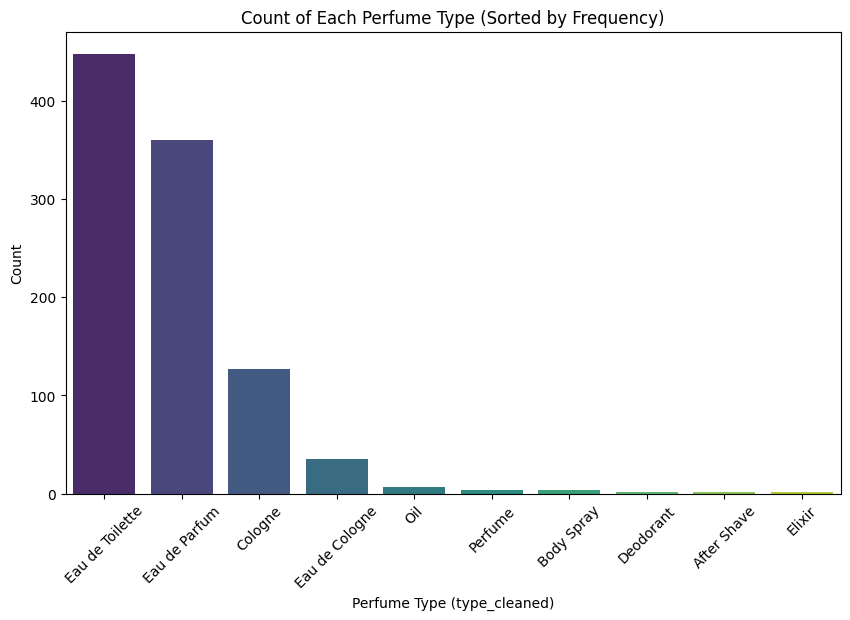

In [272]:
order = df['type_cleaned'].value_counts().index

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_cleaned', order=order, palette="viridis")

plt.title("Count of Each Perfume Type (Sorted by Frequency)")
plt.xlabel("Perfume Type (type_cleaned)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Viewing the rows still unfilled

In [273]:
unknown_rows = df[df['type_cleaned'].isna()][['title', 'type']]
unknown_rows.head(20)

,title,type
87,Arouse-Rx #1 Best Uncented Sex Pheromones For ...,Unscented
271,Versace 4pc Miniature Gift Set for Men Eau Fra...,Gift Sets
352,Lucianno California Vibe M 100ml Boxed,Extrait De Parfum
381,"Adidas Moves for Him Body Fragrance for Men, 2...",Does not apply
489,New Frederic Malle CARNAL FLOWER Dominique Rop...,Editions Parfums
745,1 Million by Paco Rabanne Men’s Sample Kit 4/pc,Various


Fill the last remaining blank with "Unspecified"

In [274]:
df['type_cleaned'] = df['type_cleaned'].fillna('Unspecified')

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              997 non-null    object 
 1   title              997 non-null    object 
 2   type               994 non-null    object 
 3   price              997 non-null    float64
 4   priceWithCurrency  997 non-null    object 
 5   available          936 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       997 non-null    object 
 10  type_cleaned       997 non-null    object 
dtypes: float64(3), object(8)
memory usage: 93.5+ KB


Since no. in Perfume and Elixir is very low and deodrant and body spary to make one cluster

In [276]:
merge_map = {
    'Perfume': 'Perfume & Elixir',
    'Elixir': 'Perfume & Elixir',
    'Deodorant': 'Spray & Deodorant',
    'Body Spray': 'Spray & Deodorant'
}

df['type_cleaned'] = df['type_cleaned'].replace(merge_map)

/tmp/ipython-input-1840998791.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type_cleaned', order=order, palette="viridis")


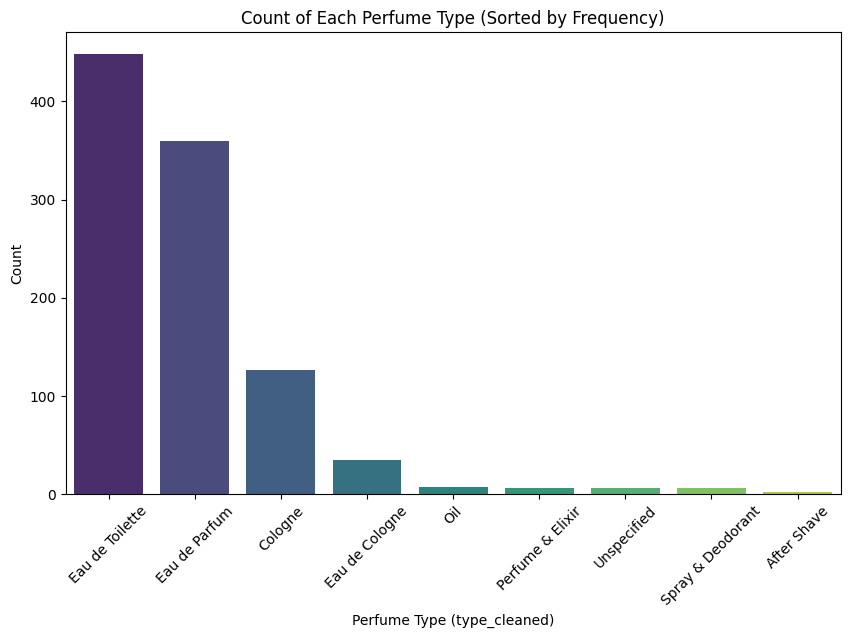

In [277]:
order = df['type_cleaned'].value_counts().index

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_cleaned', order=order, palette="viridis")

plt.title("Count of Each Perfume Type (Sorted by Frequency)")
plt.xlabel("Perfume Type (type_cleaned)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Mapping the brand column from unique brand list

In [278]:

# Ensure 'type' column is string
df['title'] = df['title'].astype(str)

master_brands = ["Afnan","Armaf","2nd To None","Ard Al Zaafaran","Al Wataniah",
    "Abercrombie & Fitch","Acqua di Parma","Adidas","aladdin","Amouage"
    "fragance one","Al Rehab","Avon", "AXE", "Azzaro", "Baron", "Bath & Body Works", "Bentley", "Bharara", "Blue Perfumes",
"BOD man",
    "Bond No. 9", "Boucheron", "Brut", "Burberry", "Bvlgari", "By Al Hambra", "Calvin Klein", "Carolina Herrera",
                 "Cartier", "CHANEL",
    "Christian Dior", "Claude Marsal", "Clinique", "Clive Christian", "Coach", "Coty Inc.", "Creed",
                 "Cuba", "CURVE",
    "Dana", "David Beckham", "Davidoff", "Designer Series", "Diesel", "Dior", "Dolce & Gabbana", "Dossier", "Dumont",
                 "Dvyne Fragrances",
    "EBC", "Ed Hardy", "El Ganso", "Elixir", "Elizabeth Taylor", "Emanuelle Ungaro", "Emporio Armani", "English Laundry",
                 "Estée Lauder",
    "Falic Fashion Group", "Fragrance Couture", "Fragrance World","FM", "Franck Olivier", "Giorgio Armani", "Giorgio Beverly Hills", "Givenchy",
    "Grandeur", "Gucci", "Guerlain", "GUESS", "Guy Laroche", "Halloween", "Halston", "Hanae Mori",
                 "Have A Scent",
    "Heaven Scents", "Hermes", "HINODE", "Hollister", "Houbigant", "HUGO BOSS", "Hybrid & Company", "Issey Miyake",
                 "J. Del Pozo",
    "Jacques Bogart", "Jaguar", "Jean Paul Gaultier", "Jil Sander", "Jimmy Choo", "Jo Malone", "John Varvatos", "Joop",
                 "Jovan", "Juicy Couture",
    "Karl Lagerfeld", "Kenneth Cole", "Kenneth Cole Reaction", "KENZO", "Khadlaj", "King", "king of kings", "L’OCCITANE",
                 "Lacoste", "Lalique",
    "Lanvin", "Lapidus", "Lattafa", "Lauren Ralph Lauren", "Liz Claiborne", "LLURE SX", "Lomani", "Louis Vuitton",
                 "Lucianno", "Luxury",
    "MACARENA", "Maison Alhambra", "Maison Francis Kurkdjian", "Maison Margiela", "Maison Martin Margiela", "Mancera",
                 "Mandarin Duck", "Mary Kay",
    "Mercedes-Benz", "MetaHerbal Labs", "MFK", "Michael Jordan", "Michael Malul", "Michel Germain", "Milestone Perfumes",
                 "Mirage Brands",
    "Missoni", "Mont Blanc", "MONTALE", "Moschino", "Myrurgia", "Narciso Rodriguez", "Nautica"," NEW CUPID", "NIKOS", "Nina Ricci",
                 "Old Spice",
    "Paco Rabanne", "Parfums de Marly", "Paris Hilton", "Paul Sebastian", "Penhaligon's", "Perry Ellis",
                 "Phillips-Van Heusen",
    "Pierre Cardin", "Prada", "Ralph Lauren", "Rasasi", "RawChemistry", "REYANE TRADITION", "Roberto Cavalli", "Rochas",
                 "Roja", "Roja Dove",
    "Roja Parfums", "rue21", "Salvatore Ferragamo", "Sean John", "SECERTMU", "Sterling", "Superz Budapest", "Ted Lapidus",
                 "Territoire",
    "The Baron", "Thierry Mugler", "Tiffany", "Tom Ford", "Tommy Bahama", "Tommy Hilfiger", "Topshelf", "Ulric de Varens",
                 "united scents",
    "UOMO", "Valentino", "Versace", "Victor & Rolf", "VICTOR MANUELLE", "Vince Camuto", "Xerjoff", "YSL", "Yves de Sistelle",
    "Yves Saint Laurent", "Zara"]

# Normalize master list for comparison
master_brands_lower = [b.lower() for b in master_brands]

def extract_brand(title):
    title_lower = title.lower()

       # Step 1: Look for 'by Brand'
    if 'by' in title_lower:
        after_by = title_lower.split('by', 1)[1]
        for brand, brand_lower in zip(master_brands, master_brands_lower):
            if brand_lower in after_by:
                return brand

    # Step 2: Fallback - check if any brand exists anywhere in title
    for brand, brand_lower in zip(master_brands, master_brands_lower):
        if brand_lower in title_lower:
            return brand

    # Step 3: Fuzzy match - require at least 80% similarity
    match = process.extractOne(title_lower, master_brands, scorer=fuzz.partial_ratio)
    if match and match[1] >= 80:  # match[1] is similarity score
        return match[0]

    # Step 4: If nothing matches
    return 'Unknown'

# Apply function to extract clean brand
df['brand_cleaned'] = df['title'].apply(extract_brand)

# Check results
print(df[['title', 'brand','brand_cleaned']].head(20))

                                                title             brand  \
0   Christian Dior Sauvage Men's EDP 3.4 oz Fragra...              Dior   
1   A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...           AS SHOW   
2                    HOGO BOSS cologne For Men 3.4 oz         Unbranded   
3   Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...    Giorgio Armani   
4   Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...           Lattafa   
5   Men's Perfume Sampler 10pcs Sample Vials Desig...   Multiple Brands   
6   Glacier Bold by Maison Alhambra 3.4oz EDP for ...   Maison Alhambra   
7   Parfums De-Marly-Haltane Eau de Parfum spray 4...         Unbranded   
8   Hawas for him Eau De Parfum By Rasasi 100ml 3....         Unbranded   
9   Gucci Guilty for Him - Classic 3oz Eau de Toil...             Gucci   
10  Polo Blue by Ralph Lauren 4.2 oz EDT Cologne f...      Ralph Lauren   
11  Dolce & Gabbana Light Blue Men 4.2 oz / 125 mL...     Dolce&Gabbana   
12  New 2024 Sexy Cologne

In [279]:
# Check results
print(df[['brand', 'brand_cleaned']].head(20))

               brand     brand_cleaned
0               Dior    Christian Dior
1            AS SHOW           Unknown
2          Unbranded         HUGO BOSS
3     Giorgio Armani    Giorgio Armani
4            Lattafa           Lattafa
5    Multiple Brands  Dvyne Fragrances
6    Maison Alhambra   Maison Alhambra
7          Unbranded  Parfums de Marly
8          Unbranded            Rasasi
9              Gucci             Gucci
10      Ralph Lauren      Ralph Lauren
11     Dolce&Gabbana   Dolce & Gabbana
12          SECERTMU         NEW CUPID
13           As Show           Unknown
14           Versace           Versace
15      Paco Rabanne      Paco Rabanne
16          Grandeur          Grandeur
17             Armaf             Armaf
18  Carolina Herrera  Carolina Herrera
19              Dior              Dior


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              997 non-null    object 
 1   title              997 non-null    object 
 2   type               994 non-null    object 
 3   price              997 non-null    float64
 4   priceWithCurrency  997 non-null    object 
 5   available          936 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       997 non-null    object 
 10  type_cleaned       997 non-null    object 
 11  brand_cleaned      997 non-null    object 
dtypes: float64(3), object(9)
memory usage: 101.3+ KB


In [281]:
placeholders = [
    "as show", "as shown", "as picture show",
    "as picture shown", "as showed",
    "picture show", "picture shown"
]

df.loc[
    (df['brand_cleaned'].str.lower() == "unknown") &
    (df['brand'].str.lower().str.contains('|'.join(placeholders))),
    'brand_cleaned'
] = "Unbranded"

In [282]:
def fix_unknown_with_master(row, master_list, threshold=90):
    if row['brand_cleaned'].lower() == 'unknown':
        # Take original brand name from 'brand' column
        brand = row['brand']

        # Fuzzy match original brand to master list
        match = process.extractOne(brand, master_list, scorer=fuzz.partial_ratio)

        if match and match[1] >= threshold:
            return match[0]  # Replace 'Unknown' with matched master brand
        else:
            return row['brand_cleaned']  # Keep as 'Unknown' if no strong match
    else:
        return row['brand_cleaned']  # Keep original if not 'Unknown'

# Apply function row-wise
df['brand_cleaned'] = df.apply(lambda row: fix_unknown_with_master(row, master_brands), axis=1)

# Check results
print(df[['brand', 'brand_cleaned']].head(20))

               brand     brand_cleaned
0               Dior    Christian Dior
1            AS SHOW         Unbranded
2          Unbranded         HUGO BOSS
3     Giorgio Armani    Giorgio Armani
4            Lattafa           Lattafa
5    Multiple Brands  Dvyne Fragrances
6    Maison Alhambra   Maison Alhambra
7          Unbranded  Parfums de Marly
8          Unbranded            Rasasi
9              Gucci             Gucci
10      Ralph Lauren      Ralph Lauren
11     Dolce&Gabbana   Dolce & Gabbana
12          SECERTMU         NEW CUPID
13           As Show         Unbranded
14           Versace           Versace
15      Paco Rabanne      Paco Rabanne
16          Grandeur          Grandeur
17             Armaf             Armaf
18  Carolina Herrera  Carolina Herrera
19              Dior              Dior


In [283]:
# Count number of unknown brands
num_unknown = len(df[df['brand_cleaned'] == 'Unknown'])
print("Number of unknown brands:", num_unknown)

# Alternatively using boolean sum
num_unknown2 = (df['brand_cleaned'] == 'Unknown').sum()
print("Number of unknown brands (alternative method):", num_unknown2)

Number of unknown brands: 26
Number of unknown brands (alternative method): 26


In [284]:
df.loc[df['availableText'].str.contains("Limited quantity available", na=False), 'available'] = 6

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              997 non-null    object 
 1   title              997 non-null    object 
 2   type               994 non-null    object 
 3   price              997 non-null    float64
 4   priceWithCurrency  997 non-null    object 
 5   available          995 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       997 non-null    object 
 10  type_cleaned       997 non-null    object 
 11  brand_cleaned      997 non-null    object 
dtypes: float64(3), object(9)
memory usage: 101.3+ KB


In [286]:
empty_rows = df[df['available'].isna()]

print(empty_rows)

       brand                                              title  \
716    Gucci  GUCCI GUILTY ELIXIR DE PARFUM POUR HOMME 0.05 ...   
934  Cologne  New 10x New Random Unique Men's Fragrance Colo...   

                 type  price priceWithCurrency  available  \
716  Elixir de Parfum  15.99         US $15.99        NaN   
934           Perfume  19.90         US $19.90        NaN   

                                         availableText   sold  \
716  More than 10 lots available (3 items per lot) ...  196.0   
934  More than 10 lots available (10 items per lot)...  331.0   

                   lastUpdated                            itemLocation  \
716  May 19, 2024 16:43:20 PDT  Valley Stream, New York, United States   
934  Nov 21, 2023 08:32:55 PST    Stony Brook, New York, United States   

      type_cleaned    brand_cleaned  
716  Eau de Parfum           Elixir  
934        Cologne  Fragrance World  


In [287]:
df.loc[
    df['availableText'].str.contains(
        "More than 10 lots available (3 items per lot) / 196 sold", na=False, regex=False
    ),
    'available'
] = 30

# Update 'available' column for the second pattern
df.loc[
    df['availableText'].str.contains(
        "More than 10 lots available (10 items per lot) / 331 sold", na=False, regex=False
    ),
    'available'
] = 30

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              997 non-null    object 
 1   title              997 non-null    object 
 2   type               994 non-null    object 
 3   price              997 non-null    float64
 4   priceWithCurrency  997 non-null    object 
 5   available          997 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       997 non-null    object 
 10  type_cleaned       997 non-null    object 
 11  brand_cleaned      997 non-null    object 
dtypes: float64(3), object(9)
memory usage: 101.3+ KB


In [289]:
df['itemlocation_cleanedcountry'] = df['itemLocation'].apply(lambda x: x.split(',')[-1].strip())

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        997 non-null    object 
 1   title                        997 non-null    object 
 2   type                         994 non-null    object 
 3   price                        997 non-null    float64
 4   priceWithCurrency            997 non-null    object 
 5   available                    997 non-null    float64
 6   availableText                997 non-null    object 
 7   sold                         994 non-null    float64
 8   lastUpdated                  947 non-null    object 
 9   itemLocation                 997 non-null    object 
 10  type_cleaned                 997 non-null    object 
 11  brand_cleaned                997 non-null    object 
 12  itemlocation_cleanedcountry  997 non-null    object 
dtypes: float64(3), object(10)

In [291]:
print(f"Missing values in 'sold' before filling with 0: {df['sold'].isnull().sum()}")

df['sold'] = df['sold'].fillna(0)

print(f"Missing values in 'sold' after filling with 0: {df['sold'].isnull().sum()}")
print(df[['title', 'sold']].head())

Missing values in 'sold' before filling with 0: 3
Missing values in 'sold' after filling with 0: 0
                                               title   sold
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...  116.0
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   48.0
2                   HOGO BOSS cologne For Men 3.4 oz   27.0
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...  159.0
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...  156.0


In [292]:
# Convert 'lastUpdated' column to datetime, coercing errors will turn unparseable dates into NaT
df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')

# Find the latest existing date (excluding NaT values)
latest_date = df['lastUpdated'].max()

# Fill empty or NaT rows with the latest date
df['lastUpdated'] = df['lastUpdated'].fillna(latest_date)

print(f"Missing values in 'lastUpdated' after filling: {df['lastUpdated'].isnull().sum()}")
print(df[['title', 'lastUpdated']].head())

Missing values in 'lastUpdated' after filling: 0
                                               title         lastUpdated
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra... 2024-05-24 10:03:04
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime... 2024-05-23 23:07:49
2                   HOGO BOSS cologne For Men 3.4 oz 2024-05-22 21:55:43
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D... 2024-05-24 03:30:43
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ... 2024-05-24 07:56:25


/tmp/ipython-input-2935002899.py:2: FutureWarning: Parsed string "May 24, 2024 10:03:04 PDT" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')


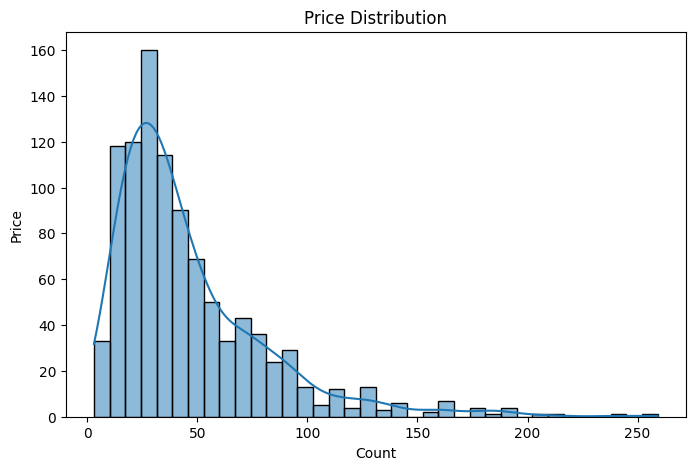

In [293]:


plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True)
plt.title("Price Distribution")
plt.xlabel("Count")
plt.ylabel("Price")
plt.show()

/tmp/ipython-input-3244274484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type_cleaned', palette="viridis")


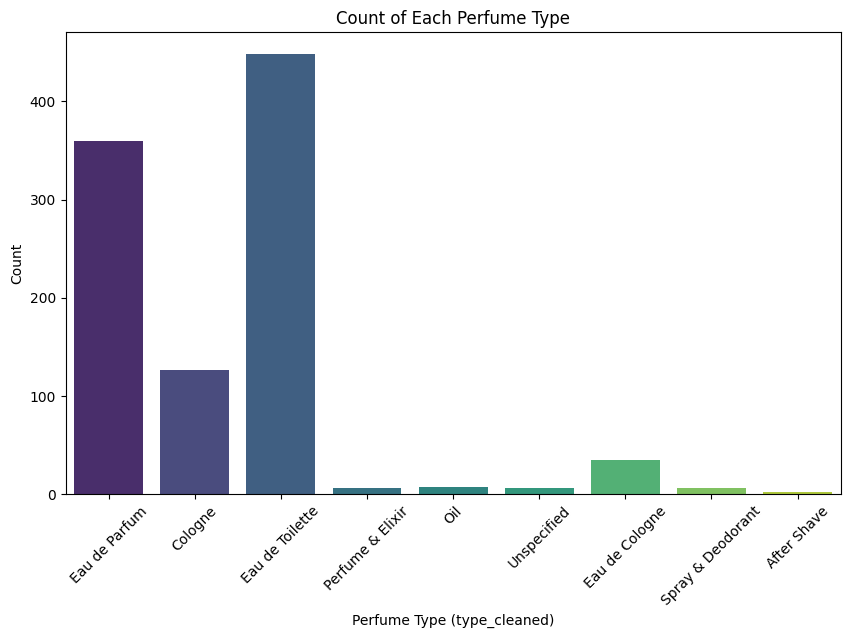

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_cleaned', palette="viridis")

plt.title("Count of Each Perfume Type")
plt.xlabel("Perfume Type (type_cleaned)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   brand                        997 non-null    object        
 1   title                        997 non-null    object        
 2   type                         994 non-null    object        
 3   price                        997 non-null    float64       
 4   priceWithCurrency            997 non-null    object        
 5   available                    997 non-null    float64       
 6   availableText                997 non-null    object        
 7   sold                         997 non-null    float64       
 8   lastUpdated                  997 non-null    datetime64[ns]
 9   itemLocation                 997 non-null    object        
 10  type_cleaned                 997 non-null    object        
 11  brand_cleaned                997 non-null    objec

Box Plot of price by type

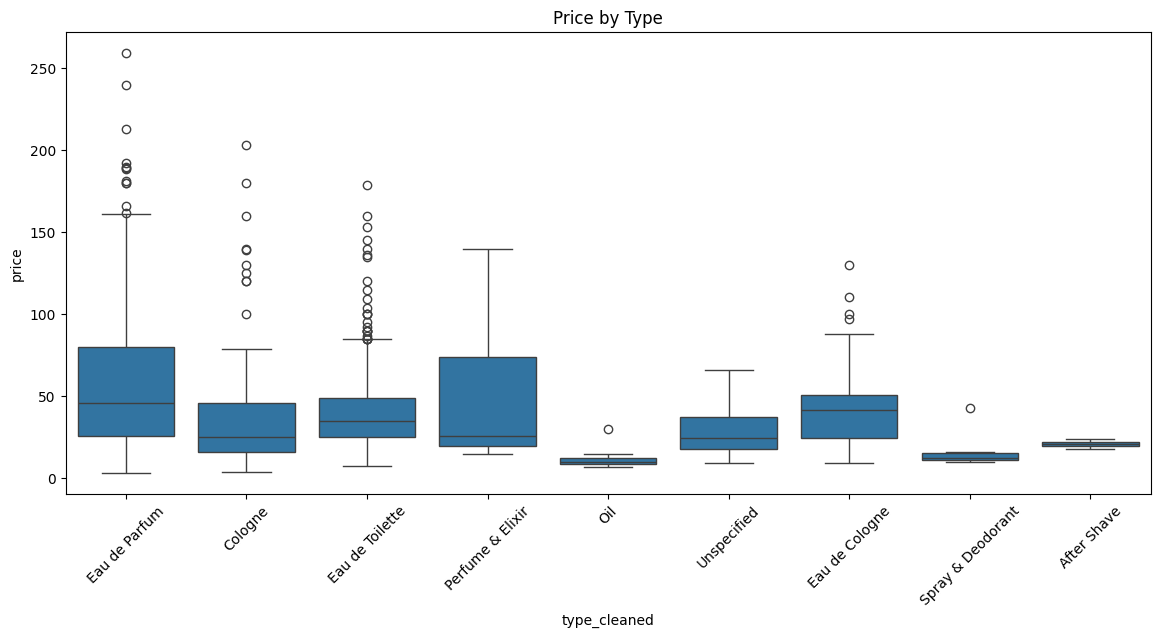

In [296]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='type_cleaned', y='price')
plt.xticks(rotation=45)
plt.title("Price by Type")
plt.show()

Heat map of average price by type

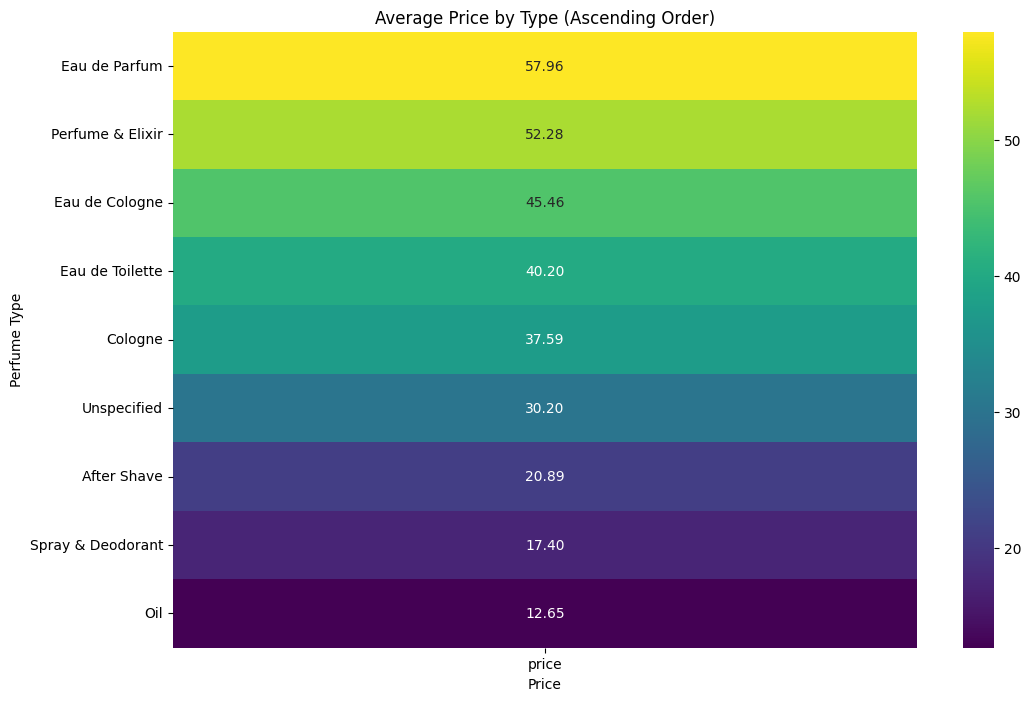

In [297]:
pivot = df.pivot_table(index='type_cleaned', values='price', aggfunc='mean')


pivot = pivot.sort_values(by='price', ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")

plt.title("Average Price by Type (Ascending Order)")
plt.xlabel("Price")
plt.ylabel("Perfume Type")
plt.show()

Bar graph showing total volume by of sold

/tmp/ipython-input-2476943358.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


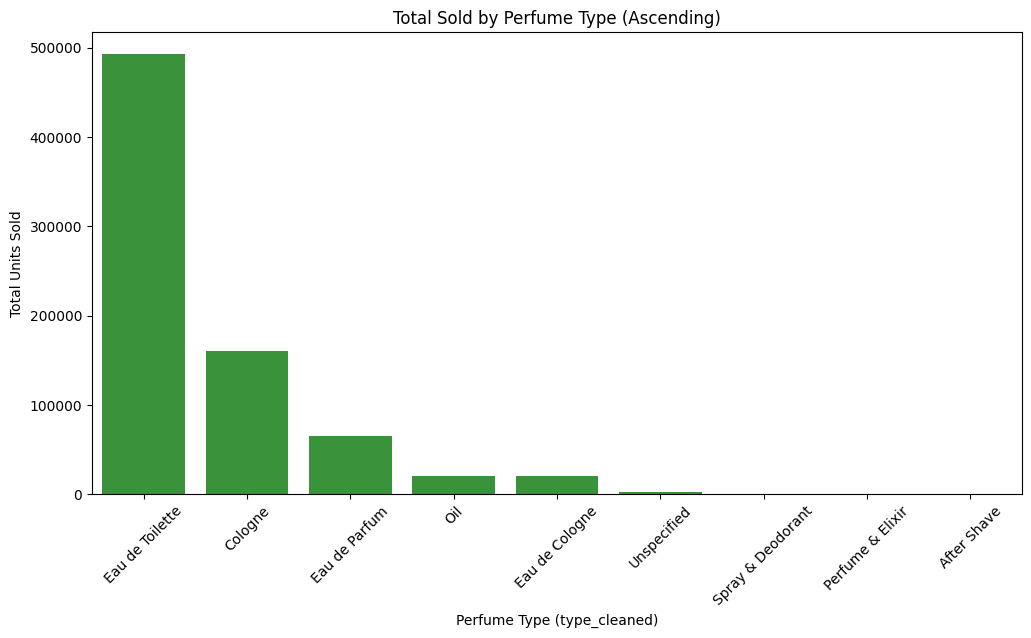

In [298]:

sorted_types = (
    df.groupby('type_cleaned')['sold']
      .sum()
      .sort_values(ascending=False)
      .index
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='type_cleaned',
    y='sold',
    estimator='sum',
    order=sorted_types,
    color='tab:green',
    ci=None   #
)

plt.title("Total Sold by Perfume Type (Ascending)")
plt.xlabel("Perfume Type (type_cleaned)")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)

plt.show()


Pivot table of type

In [299]:
pivot_table = pd.pivot_table(
    df,
    index='type_cleaned',
    values=['sold', 'price'],
    aggfunc={'sold': 'sum'}
)


pivot_table.columns = [col.upper() for col in pivot_table.columns]


pivot_table.index.name = 'TYPE_CLEANED'

pivot_table = pivot_table.sort_values(by='SOLD', ascending=False)


# Display as a clean table
print(pivot_table.to_string())

                       SOLD
TYPE_CLEANED               
Eau de Toilette    492751.0
Cologne            159919.0
Eau de Parfum       64973.0
Oil                 20434.0
Eau de Cologne      20308.0
Unspecified          2251.0
Spray & Deodorant     715.0
Perfume & Elixir      232.0
After Shave            86.0


Bar graph showing total available unit by Perfume type

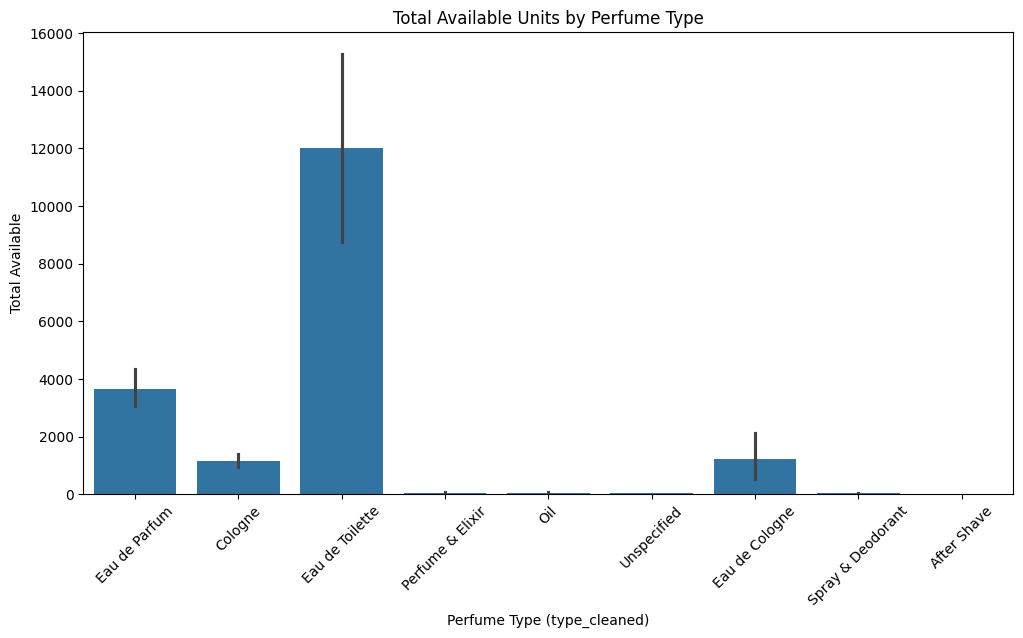

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='type_cleaned',
    y='available',
    estimator='sum'
)

plt.title("Total Available Units by Perfume Type")
plt.xlabel("Perfume Type (type_cleaned)")
plt.ylabel("Total Available")
plt.xticks(rotation=45)

plt.show()

TOP 20 BRAND BY NUMBER OF LISTINGS

/tmp/ipython-input-3264316081.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


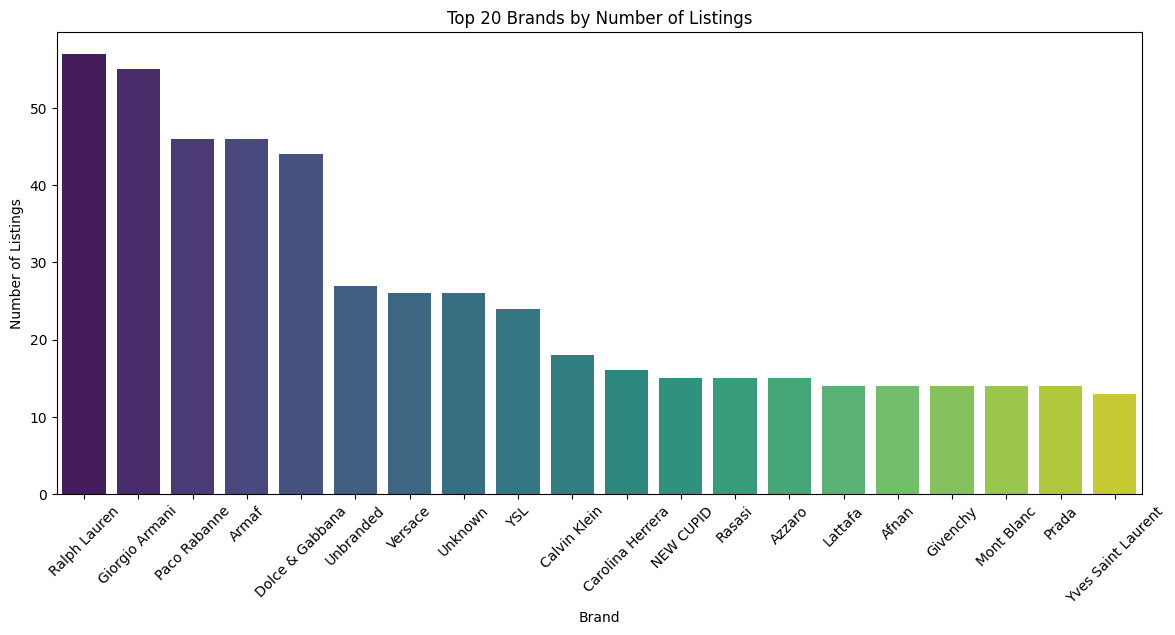

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt


top_brands_counts = df['brand_cleaned'].value_counts().head(20)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=top_brands_counts.index,
    y=top_brands_counts.values,
    palette="viridis"
)

plt.title("Top 20 Brands by Number of Listings")
plt.xlabel("Brand")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.show()


TOP 10 BRANDS BY UNITS SOLD

/tmp/ipython-input-2804009734.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_brands.index, y=top_10_brands.values, palette="magma")


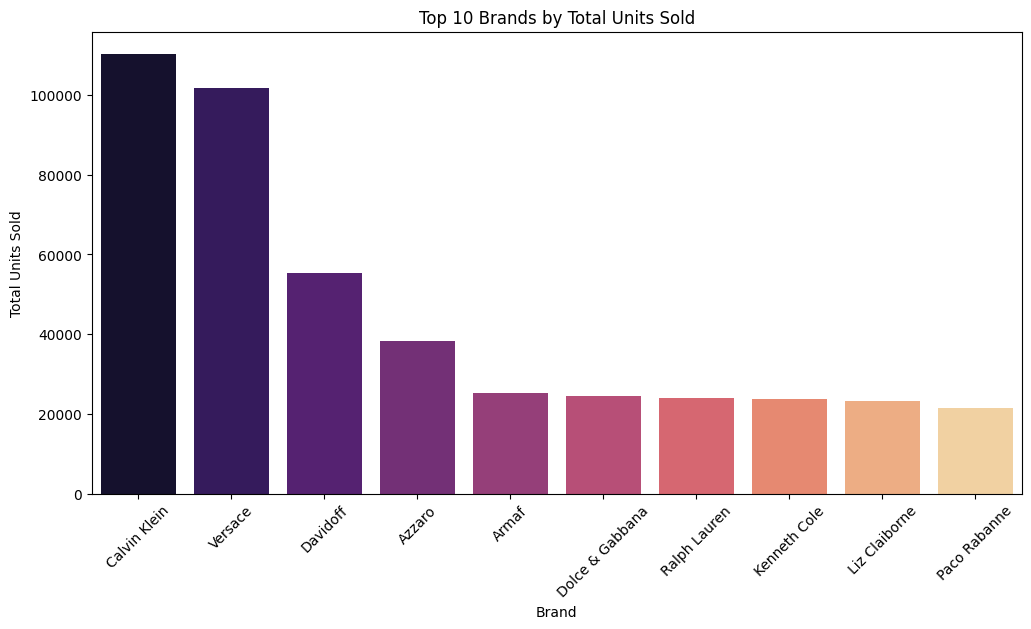

In [302]:
brand_sold = df.groupby('brand_cleaned')['sold'].sum()


top_10_brands = brand_sold.sort_values(ascending=False).head(10)


plt.figure(figsize=(12,6))
sns.barplot(x=top_10_brands.index, y=top_10_brands.values, palette="magma")

plt.title("Top 10 Brands by Total Units Sold")
plt.xlabel("Brand")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.show()

Correlation heapmap between numeric variables

Correlation Matrix:
              price      sold  available
price      1.000000 -0.084177  -0.101296
sold      -0.084177  1.000000   0.098475
available -0.101296  0.098475   1.000000


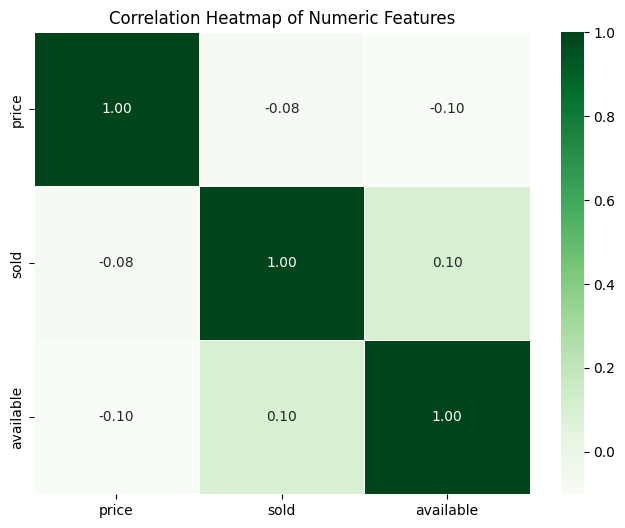

In [303]:
numeric_vars = ['price', 'sold', 'available']

corr_matrix = df[numeric_vars].corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Greens", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Scaling and encoding the data

In [304]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['price', 'sold']
scaled_numerical = pd.DataFrame(
    StandardScaler().fit_transform(df[numerical_features]),
    columns=[f"{col}_scaled" for col in numerical_features],
    index=df.index
)

categorical_features = ['type_cleaned']
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)


X = pd.concat([scaled_numerical[['price_scaled','sold_scaled']], df_encoded], axis=1)

K MEANS CLUSTER

In [305]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

print("WCSS values for 1 to 10 clusters:")
print(wcss)

WCSS values for 1 to 10 clusters:
[2640.138415245739, 1943.0330681020782, 1268.9145681529556, 982.1731457126918, 825.833215425983, 678.2190031766471, 547.0649082416346, 473.6484438888836, 405.57551622579524, 367.11782362644334]


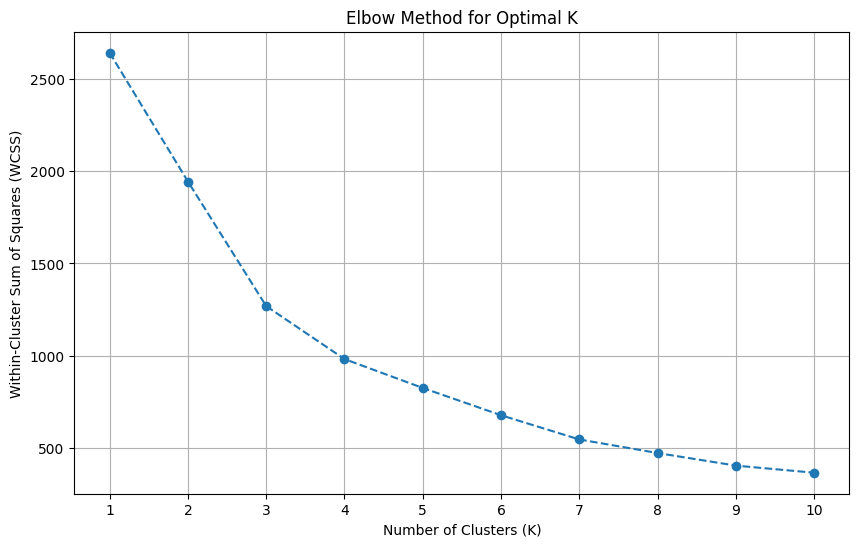

In [306]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

 K-Means clustering using optimal K




In [307]:
k_optimal = 3

kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X)

print(f"K-Means clustering performed with {k_optimal} clusters.")
print("First 5 rows with K-Means cluster labels:")
print(df[['title', 'brand_cleaned', 'type_cleaned', 'price', 'kmeans_cluster']].head())

K-Means clustering performed with 3 clusters.
First 5 rows with K-Means cluster labels:
                                               title   brand_cleaned  \
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...  Christian Dior   
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...       Unbranded   
2                   HOGO BOSS cologne For Men 3.4 oz       HUGO BOSS   
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...  Giorgio Armani   
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...         Lattafa   

      type_cleaned   price  kmeans_cluster  
0    Eau de Parfum   84.99               0  
1    Eau de Parfum  109.99               0  
2          Cologne  100.00               0  
3  Eau de Toilette   44.99               1  
4    Eau de Parfum   16.91               1  


In [308]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score_kmeans = silhouette_score(X, df['kmeans_cluster'])
print("Silhouette Score for KMeans:", sil_score_kmeans)

dbi_kmeans = davies_bouldin_score(X, df['kmeans_cluster'])
print(f"Davies-Bouldin Index for KMeans with k={k_optimal}: {dbi_kmeans:.4f}")

Silhouette Score for KMeans: 0.42917957488369435
Davies-Bouldin Index for KMeans with k=3: 0.8016


In [309]:
print("K-Means cluster size distribution:")
print(df['kmeans_cluster'].value_counts())


K-Means cluster size distribution:
kmeans_cluster
1    779
0    210
2      8
Name: count, dtype: int64


In [310]:


# ----- K-Means Cluster Means (Original Scale) -----
cluster_means_kmeans = df.groupby('kmeans_cluster')[['price', 'sold']].mean()
print("Mean characteristics of K-Means clusters (original scale):\n")
print(tabulate(cluster_means_kmeans, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))

# ----- K-Means Cluster Means (Scaled + Encoded) -----
X_with_clusters = X.copy()
X_with_clusters['kmeans_cluster'] = df['kmeans_cluster']
cluster_means_scaled_encoded = X_with_clusters.groupby('kmeans_cluster').mean()

print("\nMean characteristics of K-Means clusters (scaled and one-hot encoded features):\n")
print(tabulate(cluster_means_scaled_encoded, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))


Mean characteristics of K-Means clusters (original scale):

╒══════════════════╤═════════╤═══════════╕
│   kmeans_cluster │   price │      sold │
╞══════════════════╪═════════╪═══════════╡
│                0 │  99.781 │   139.862 │
├──────────────────┼─────────┼───────────┤
│                1 │  31.799 │   631.071 │
├──────────────────┼─────────┼───────────┤
│                2 │  30.906 │ 30086.750 │
╘══════════════════╧═════════╧═══════════╛

Mean characteristics of K-Means clusters (scaled and one-hot encoded features):

╒══════════════════╤════════════════╤═══════════════╤════════════════════════╤═══════════════════════════════╤══════════════════════════════╤════════════════════════════════╤════════════════════╤═════════════════════════════════╤══════════════════════════════════╤════════════════════════════╕
│   kmeans_cluster │   price_scaled │   sold_scaled │   type_cleaned_Cologne │   type_cleaned_Eau de Cologne │   type_cleaned_Eau de Parfum │   type_cleaned_Eau de Toilette │   

In [311]:
from tabulate import tabulate
cluster_means_kmeans = df.groupby('kmeans_cluster')[['price', 'sold']].mean()

cluster_counts = df['kmeans_cluster'].value_counts().sort_index()


cluster_means_kmeans['count'] = cluster_counts

print("Mean characteristics of K-Means clusters (original scale):\n")
print(tabulate(cluster_means_kmeans, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))


X_with_clusters = X.copy()
X_with_clusters['kmeans_cluster'] = df['kmeans_cluster']
cluster_means_scaled_encoded = X_with_clusters.groupby('kmeans_cluster').mean()

cluster_means_scaled_encoded['count'] = cluster_counts

print("\nMean characteristics of K-Means clusters (scaled and one-hot encoded features):\n")
print(tabulate(cluster_means_scaled_encoded, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))


Mean characteristics of K-Means clusters (original scale):

╒══════════════════╤═════════╤═══════════╤═════════╕
│   kmeans_cluster │   price │      sold │   count │
╞══════════════════╪═════════╪═══════════╪═════════╡
│                0 │  99.781 │   139.862 │ 210.000 │
├──────────────────┼─────────┼───────────┼─────────┤
│                1 │  31.799 │   631.071 │ 779.000 │
├──────────────────┼─────────┼───────────┼─────────┤
│                2 │  30.906 │ 30086.750 │   8.000 │
╘══════════════════╧═════════╧═══════════╧═════════╛

Mean characteristics of K-Means clusters (scaled and one-hot encoded features):

╒══════════════════╤════════════════╤═══════════════╤════════════════════════╤═══════════════════════════════╤══════════════════════════════╤════════════════════════════════╤════════════════════╤═════════════════════════════════╤══════════════════════════════════╤════════════════════════════╤═════════╕
│   kmeans_cluster │   price_scaled │   sold_scaled │   type_cleaned_Cologne 

In [312]:
cols = ['cluster', 'brand_cleaned', 'type_cleaned', 'price', 'available', 'sold']

for c in sorted(df['kmeans_cluster'].unique()):
    print(f"\nCluster {c}:")
    display(df[df['kmeans_cluster'] == c][['brand_cleaned', 'type_cleaned', 'price', 'available', 'sold']])



Cluster 0:


,brand_cleaned,type_cleaned,price,available,sold
0,Christian Dior,Eau de Parfum,84.99,10.0,116.0
1,Unbranded,Eau de Parfum,109.99,8.0,48.0
2,HUGO BOSS,Cologne,100.00,10.0,27.0
7,Parfums de Marly,Eau de Parfum,85.00,1.0,6.0
13,Unbranded,Eau de Parfum,59.99,9.0,63.0
...,...,...,...,...,...
975,Givenchy,Eau de Parfum,80.00,10.0,197.0
978,Dolce & Gabbana,Eau de Parfum,91.00,3.0,1.0
980,Maison Margiela,Eau de Toilette,84.98,8.0,42.0
983,Carolina Herrera,Eau de Parfum,59.99,10.0,496.0



Cluster 1:


,brand_cleaned,type_cleaned,price,available,sold
3,Giorgio Armani,Eau de Toilette,44.99,2.0,159.0
4,Lattafa,Eau de Parfum,16.91,6.0,156.0
5,Dvyne Fragrances,Perfume & Elixir,14.99,10.0,79.0
6,Maison Alhambra,Eau de Parfum,30.99,9.0,39.0
8,Rasasi,Eau de Parfum,15.89,10.0,17.0
...,...,...,...,...,...
995,GUESS,Eau de Toilette,20.28,45.0,1613.0
996,Armaf,Eau de Toilette,30.58,10.0,31.0
997,Paco Rabanne,Eau de Toilette,39.99,2.0,305.0
998,Lomani,Eau de Toilette,9.99,2.0,22.0



Cluster 2:


,brand_cleaned,type_cleaned,price,available,sold
44,Azzaro,Eau de Toilette,46.33,6.0,30655.0
57,Versace,Eau de Toilette,36.88,6.0,19899.0
61,2nd To None,Oil,6.65,9.0,18882.0
76,Calvin Klein,Eau de Toilette,23.56,6.0,24048.0
81,Calvin Klein,Cologne,23.89,6.0,54052.0
184,Versace,Eau de Toilette,39.77,6.0,31718.0
188,Versace,Eau de Toilette,44.94,10.0,21310.0
642,Davidoff,Eau de Toilette,25.23,6.0,40130.0


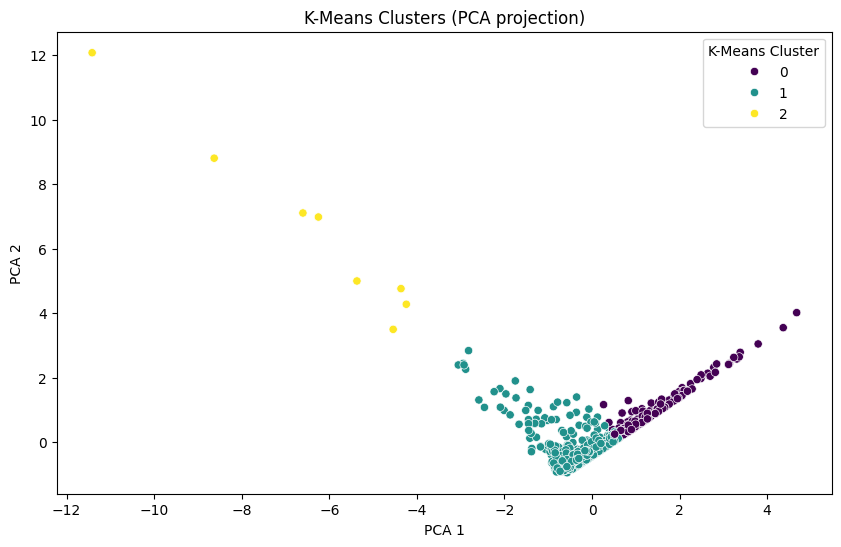

In [313]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['kmeans_cluster'], palette="viridis")
plt.title("K-Means Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='K-Means Cluster')
plt.show()

Mean characteristics of  K MEANS cluster

In [314]:

cluster_means_kmeans = (
    df.groupby('kmeans_cluster')[['price', 'available', 'sold']]
      .mean()
      .round(2)
)


print("Mean characteristics of K-Means clusters (original scale):\n")
display(cluster_means_kmeans.style.set_caption("K-Means Cluster Mean Values")
                                         .set_table_styles([
                                             {'selector': 'caption',
                                              'props': [('font-size', '14px'),
                                                        ('font-weight', 'bold'),
                                                        ('text-align', 'center')]}
                                         ]))

Mean characteristics of K-Means clusters (original scale):



,price,available,sold
kmeans_cluster,,,
0,99.780000,6.710000,139.860000
1,31.800000,21.590000,631.070000
2,30.910000,6.880000,30086.750000


In [315]:
cluster_sizes = df['kmeans_cluster'].value_counts().sort_index()

cluster_sizes_df = cluster_sizes.reset_index()
cluster_sizes_df.columns = ['Cluster', 'Count']

print("K-Means Cluster Size Distribution:")
display(cluster_sizes_df)

K-Means Cluster Size Distribution:


,Cluster,Count
0,0,210
1,1,779
2,2,8


In [316]:

cluster_means_kmeans = (
    df.groupby('kmeans_cluster')[['price', 'available', 'sold']]
      .mean()
      .round(2)
)


print("Mean characteristics of K-Means clusters (original scale):\n")
print(cluster_means_kmeans.to_string())



Mean characteristics of K-Means clusters (original scale):

                price  available      sold
kmeans_cluster                            
0               99.78       6.71    139.86
1               31.80      21.59    631.07
2               30.91       6.88  30086.75


DBSCAN

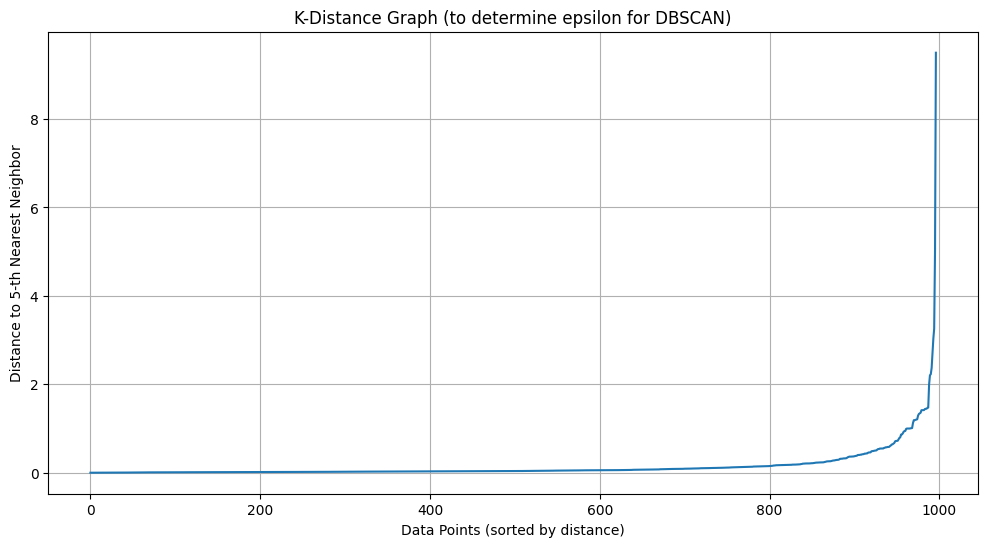

In [317]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

min_samples = 5

neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)


distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title('K-Distance Graph (to determine epsilon for DBSCAN)')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'Distance to {min_samples}-th Nearest Neighbor')
plt.grid(True)
plt.show()

In [318]:
def evaluate_dbscan_eps(X, eps_values=[0.5, 1.0, 1.1, 1.5], min_samples=5):
    results = []
    print("DBSCAN evaluation started...\n")

    for eps in eps_values:
        print(f"Testing eps = {eps} ...")

        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)

        noise_count = (labels == -1).sum()
        unique_clusters = set(labels)
        if -1 in unique_clusters:
            unique_clusters.remove(-1)
        cluster_count = len(unique_clusters)
        if cluster_count >= 2:
            mask = labels != -1
            sil_score = silhouette_score(X[mask], labels[mask])
            dbi_score = davies_bouldin_score(X[mask], labels[mask])
        else:
            sil_score = None
            dbi_score = None
        results.append({
            "eps": eps,
            "Clusters": cluster_count,
            "Noise Points": noise_count,
            "Silhouette Score": sil_score,
            "Davies-Bouldin Index": dbi_score
        })

    print("\nDBSCAN evaluation complete!")
    return pd.DataFrame(results)

results_table = evaluate_dbscan_eps(X, eps_values=[0.5, 1, 1.1, 1.5], min_samples=5)

print("\n=== DBSCAN Evaluation Results ===")
print(results_table)



DBSCAN evaluation started...

Testing eps = 0.5 ...
Testing eps = 1 ...
Testing eps = 1.1 ...
Testing eps = 1.5 ...

DBSCAN evaluation complete!

=== DBSCAN Evaluation Results ===
   eps  Clusters  Noise Points  Silhouette Score  Davies-Bouldin Index
0  0.5         8            49          0.390884              0.740618
1  1.0         7            23          0.401657              0.968588
2  1.1         1            18               NaN                   NaN
3  1.5         1             8               NaN                   NaN


In [319]:
dbsc = DBSCAN(eps=1, min_samples=5)
df['dbscan_cluster'] = dbsc.fit_predict(X)

print("DBSCAN clustering performed.")
print("First 5 rows with DBSCAN cluster labels:")
print(df[['title', 'brand_cleaned', 'type_cleaned', 'price', 'dbscan_cluster']].head())

DBSCAN clustering performed.
First 5 rows with DBSCAN cluster labels:
                                               title   brand_cleaned  \
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...  Christian Dior   
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...       Unbranded   
2                   HOGO BOSS cologne For Men 3.4 oz       HUGO BOSS   
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...  Giorgio Armani   
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...         Lattafa   

      type_cleaned   price  dbscan_cluster  
0    Eau de Parfum   84.99               0  
1    Eau de Parfum  109.99               0  
2          Cologne  100.00               1  
3  Eau de Toilette   44.99               2  
4    Eau de Parfum   16.91               0  


In [320]:
# Remove noise points (-1) for silhouette score
mask = df['dbscan_cluster'] != -1
sil_score = silhouette_score(X[mask], df.loc[mask, 'dbscan_cluster'])
print("Silhouette Score (without noise):", sil_score)


db_score = davies_bouldin_score(X[mask], df.loc[mask, 'dbscan_cluster'])
print("Davies-Bouldin Index (without noise):", db_score)

Silhouette Score (without noise): 0.40165746110672856
Davies-Bouldin Index (without noise): 0.9685875716710522


In [321]:
clusters = df['dbscan_cluster'].nunique() - (1 if -1 in df['dbscan_cluster'].values else 0)
noise_points = (df['dbscan_cluster'] == -1).sum()
print(f"Number of clusters: {clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 7
Number of noise points: 23


In [322]:
cluster_means_dbscan = df[df['dbscan_cluster'] != -1].groupby('dbscan_cluster')[['price', 'sold']].mean()
print("Mean characteristics of DBSCAN clusters (original scale, excluding noise):")
print(cluster_means_dbscan)

Mean characteristics of DBSCAN clusters (original scale, excluding noise):
                    price        sold
dbscan_cluster                       
0               57.290694  179.222222
1               36.365968  744.354839
2               40.380594  626.986301
3               30.200000  375.166667
4               45.800000  402.176471
5               17.400000  119.166667
6               13.655000  258.666667


PCA VISUALIZATION (DBSCAN)

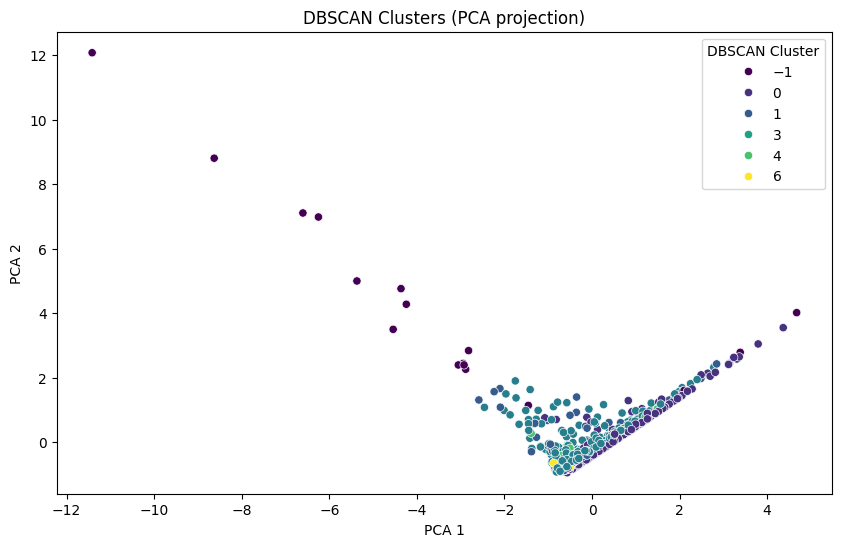

In [323]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['dbscan_cluster'], palette="viridis")
plt.title("DBSCAN Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='DBSCAN Cluster')
plt.show()

Mean characteristics, excluding noise (-1)

In [324]:
X_with_dbscan_clusters = X.copy()
X_with_dbscan_clusters['dbscan_cluster'] = df['dbscan_cluster']

cluster_means_scaled_encoded_dbscan = (
    X_with_dbscan_clusters[X_with_dbscan_clusters['dbscan_cluster'] != -1]
    .groupby('dbscan_cluster')
    .mean()
    .round(3)
    .sort_index()
)

print("\nMean characteristics of DBSCAN clusters (scaled + one-hot encoded):")
print(cluster_means_scaled_encoded_dbscan.to_string())



Mean characteristics of DBSCAN clusters (scaled + one-hot encoded):
                price_scaled  sold_scaled  type_cleaned_Cologne  type_cleaned_Eau de Cologne  type_cleaned_Eau de Parfum  type_cleaned_Eau de Toilette  type_cleaned_Oil  type_cleaned_Perfume & Elixir  type_cleaned_Spray & Deodorant  type_cleaned_Unspecified
dbscan_cluster                                                                                                                                                                                                                                                   
0                      0.322       -0.183                   0.0                          0.0                       0.997                           0.0               0.0                            0.0                             0.0                       0.0
1                     -0.281       -0.006                   1.0                          0.0                       0.000                           0.0       

DBSCAN CLUSTER SIZE DISTRIBUTION

In [325]:
print("DBSCAN cluster size distribution:")
print(df['dbscan_cluster'].value_counts())

DBSCAN cluster size distribution:
dbscan_cluster
 2    438
 0    360
 1    124
 4     34
-1     23
 3      6
 5      6
 6      6
Name: count, dtype: int64


Hierarchical Clusterning Dendogram using ward linkage

In [326]:
Z = linkage(X, method='ward')

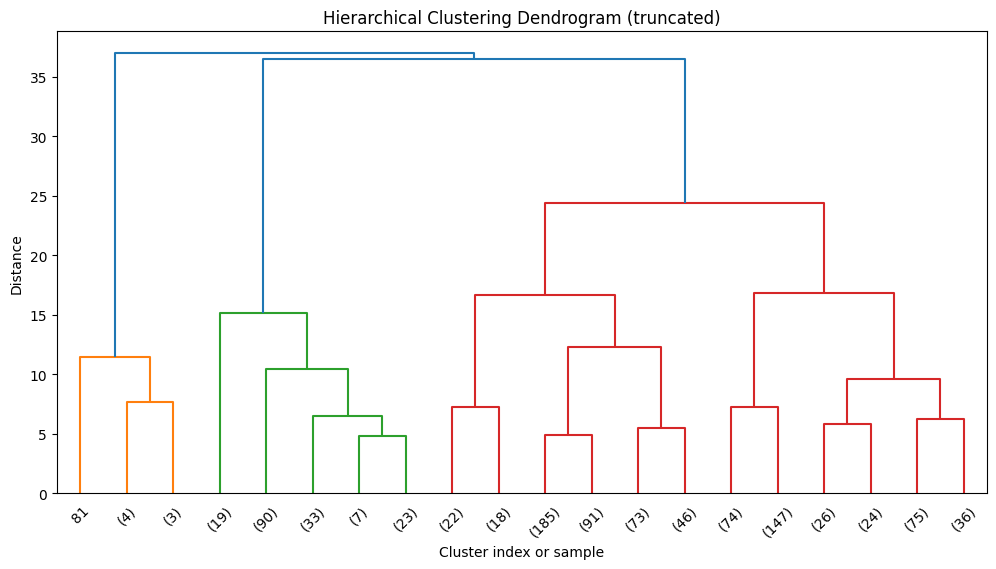

In [327]:
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=45, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster index or sample")
plt.ylabel("Distance")
plt.show()

In [328]:
from scipy.cluster.hierarchy import fcluster

k = 3 # Assuming optimal k=3 from previous analysis or dendrogram
df['hier_cluster'] = fcluster(Z, k, criterion='maxclust')

cluster_means_hierarchical = df.groupby('hier_cluster')[['price', 'sold']].mean()
print("Mean characteristics of Hierarchical clusters (original scale):")
print(cluster_means_hierarchical)

Mean characteristics of Hierarchical clusters (original scale):
                   price          sold
hier_cluster                          
1              30.906250  30086.750000
2             104.818314    113.802326
3              33.899914    613.709914


In [329]:
print("Hierarchical cluster size distribution:")
print(df['hier_cluster'].value_counts())

Hierarchical cluster size distribution:
hier_cluster
3    817
2    172
1      8
Name: count, dtype: int64


In [330]:
k = 3
df['hier_cluster'] = fcluster(Z, k, criterion='maxclust')

print(df[['type_cleaned','price','sold','hier_cluster']].head())

      type_cleaned   price   sold  hier_cluster
0    Eau de Parfum   84.99  116.0             2
1    Eau de Parfum  109.99   48.0             2
2          Cologne  100.00   27.0             2
3  Eau de Toilette   44.99  159.0             3
4    Eau de Parfum   16.91  156.0             3


PCA VISUALIZATION (HIERARCHICAL CLUSTER)

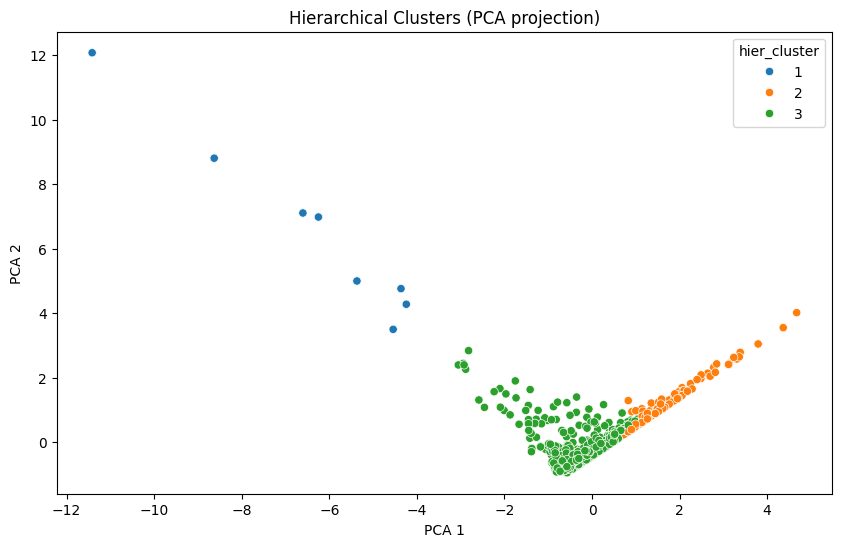

In [331]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['hier_cluster'], palette="tab10")
plt.title("Hierarchical Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Silhoutte and Davies-Bouldin Index Hierarchical Score

In [332]:
sil_score_Hierarchica = silhouette_score(X, df['hier_cluster'])
print("Silhouette Score Hierarchical Cluster:", sil_score)

db_score_Hierarchical = davies_bouldin_score(X, df['hier_cluster'])
print("Davies-Bouldin Index Hierarchical Cluster:", db_score)

Silhouette Score Hierarchical Cluster: 0.40165746110672856
Davies-Bouldin Index Hierarchical Cluster: 0.9685875716710522


In [333]:
results_hierarchical = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index'],
    'Value': [sil_score_Hierarchica, db_score_Hierarchical],
    'Number of Clusters': [k, k]
})

display(results_hierarchical)

,Metric,Value,Number of Clusters
0,Silhouette Score,0.441289,3
1,Davies-Bouldin Index,0.758447,3


Cluster detail (Hierarchical Cluster)

In [334]:
cols = ['cluster', 'brand_cleaned', 'type_cleaned', 'price', 'available', 'sold']

for c in sorted(df['hier_cluster'].unique()):
    print(f"\nCluster {c}:")
    display(df[df['hier_cluster'] == c][['brand_cleaned', 'type_cleaned', 'price', 'available', 'sold']])


Cluster 1:


,brand_cleaned,type_cleaned,price,available,sold
44,Azzaro,Eau de Toilette,46.33,6.0,30655.0
57,Versace,Eau de Toilette,36.88,6.0,19899.0
61,2nd To None,Oil,6.65,9.0,18882.0
76,Calvin Klein,Eau de Toilette,23.56,6.0,24048.0
81,Calvin Klein,Cologne,23.89,6.0,54052.0
184,Versace,Eau de Toilette,39.77,6.0,31718.0
188,Versace,Eau de Toilette,44.94,10.0,21310.0
642,Davidoff,Eau de Toilette,25.23,6.0,40130.0



Cluster 2:


,brand_cleaned,type_cleaned,price,available,sold
0,Christian Dior,Eau de Parfum,84.99,10.0,116.0
1,Unbranded,Eau de Parfum,109.99,8.0,48.0
2,HUGO BOSS,Cologne,100.00,10.0,27.0
7,Parfums de Marly,Eau de Parfum,85.00,1.0,6.0
15,Paco Rabanne,Eau de Parfum,68.99,2.0,20.0
...,...,...,...,...,...
963,Emporio Armani,Eau de Parfum,94.99,10.0,420.0
973,Nina Ricci,Eau de Toilette,120.00,3.0,7.0
975,Givenchy,Eau de Parfum,80.00,10.0,197.0
978,Dolce & Gabbana,Eau de Parfum,91.00,3.0,1.0



Cluster 3:


,brand_cleaned,type_cleaned,price,available,sold
3,Giorgio Armani,Eau de Toilette,44.99,2.0,159.0
4,Lattafa,Eau de Parfum,16.91,6.0,156.0
5,Dvyne Fragrances,Perfume & Elixir,14.99,10.0,79.0
6,Maison Alhambra,Eau de Parfum,30.99,9.0,39.0
8,Rasasi,Eau de Parfum,15.89,10.0,17.0
...,...,...,...,...,...
995,GUESS,Eau de Toilette,20.28,45.0,1613.0
996,Armaf,Eau de Toilette,30.58,10.0,31.0
997,Paco Rabanne,Eau de Toilette,39.99,2.0,305.0
998,Lomani,Eau de Toilette,9.99,2.0,22.0


Clustering Result between different methods

In [335]:
clustering_results = pd.DataFrame({
    'Clustering Method': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Silhouette Score': [sil_score_kmeans, sil_score, sil_score_Hierarchica],
    'Davies-Bouldin Index': [dbi_kmeans, db_score, db_score_Hierarchical],
    'Number of Clusters': [k_optimal, clusters, k]
})

display(clustering_results)

,Clustering Method,Silhouette Score,Davies-Bouldin Index,Number of Clusters
0,K-Means,0.429180,0.801589,3
1,DBSCAN,0.401657,0.968588,7
2,Hierarchical,0.441289,0.758447,3


In [336]:
def nice_table(title, series):
    df_table = series.sort_index().reset_index()
    df_table.columns = ['Cluster', 'Count']
    print(title)
    display(df_table)

# K-Means cluster sizes
nice_table("K-Means Cluster Sizes:", df['kmeans_cluster'].value_counts())

# DBSCAN cluster sizes
nice_table("DBSCAN Cluster Sizes:", df['dbscan_cluster'].value_counts())

# Hierarchical cluster sizes
nice_table("Hierarchical Cluster Sizes:", df['hier_cluster'].value_counts())


K-Means Cluster Sizes:


,Cluster,Count
0,0,210
1,1,779
2,2,8


DBSCAN Cluster Sizes:


,Cluster,Count
0,-1,23
1,0,360
2,1,124
3,2,438
4,3,6
5,4,34
6,5,6
7,6,6


Hierarchical Cluster Sizes:


,Cluster,Count
0,1,8
1,2,172
2,3,817


COMPARISON OF CLUSTER BETWEEN DIFFERENT CLUSTERS

In [337]:
# KMeans vs Hierarchical
print("KMeans vs Hierarchical:")
ct_k_h = pd.crosstab(df['kmeans_cluster'], df['hier_cluster'])
display(ct_k_h.style.set_caption("KMeans vs Hierarchical Clustering"))

# KMeans vs DBSCAN
print("\nKMeans vs DBSCAN:")
ct_k_d = pd.crosstab(df['kmeans_cluster'], df['dbscan_cluster'])
display(ct_k_d.style.set_caption("KMeans vs DBSCAN Clustering"))

# Hierarchical vs DBSCAN
print("\nHierarchical vs DBSCAN:")
ct_h_d = pd.crosstab(df['hier_cluster'], df['dbscan_cluster'])
display(ct_h_d.style.set_caption("Hierarchical vs DBSCAN Clustering"))


KMeans vs Hierarchical:


hier_cluster,1,2,3
kmeans_cluster,,,
0,0,172,38
1,0,0,779
2,8,0,0



KMeans vs DBSCAN:


dbscan_cluster,-1,0,1,2,3,4,5,6
kmeans_cluster,,,,,,,,
0,4,147,14,38,0,7,0,0
1,11,213,110,400,6,27,6,6
2,8,0,0,0,0,0,0,0



Hierarchical vs DBSCAN:


dbscan_cluster,-1,0,1,2,3,4,5,6
hier_cluster,,,,,,,,
1,8,0,0,0,0,0,0,0
2,4,138,9,14,0,7,0,0
3,11,222,115,424,6,27,6,6
